In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Block 1: Import necessary libraries
import pandas as pd
import numpy as np
import random
from io import StringIO  # If loading from string, otherwise use pd.read_csv('file.csv')

In [3]:
# Block 2: Load the dataset
# If the data is in a file, use: df = pd.read_csv('FedCycleData.csv')
# Since provided in text, assume you paste the full content into data_string
# data_string = """paste the full CSV content here"""
# df = pd.read_csv(StringIO(data_string))

# For now, assuming file upload in Colab or local file
df = pd.read_csv('/content/drive/MyDrive/Capstone/FedCycleData.csv')

# Clean column names and data
df.columns = df.columns.str.strip()
numeric_cols = ['LengthofCycle', 'EstimatedDayofOvulation', 'LengthofLutealPhase', 'UnusualBleeding', 'Age',
                'MeanBleedingIntensity', 'StdCycleLength']  # Add more as needed
for col in df.columns:
    if col in numeric_cols or 'Score' in col or 'Length' in col or 'Total' in col:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.fillna(0, inplace=True)  # Handle missing values appropriately
print(df.head())

  ClientID  CycleNumber  Group  CycleWithPeakorNot  ReproductiveCategory  \
0  nfp8122            1      0                   1                     0   
1  nfp8122            2      0                   1                     0   
2  nfp8122            3      0                   1                     0   
3  nfp8122            4      0                   1                     0   
4  nfp8122            5      0                   1                     0   

   LengthofCycle  MeanCycleLength  EstimatedDayofOvulation  \
0             29            27.33                     17.0   
1             27             0.00                     15.0   
2             29             0.00                     15.0   
3             27             0.00                     15.0   
4             28             0.00                     16.0   

   LengthofLutealPhase FirstDayofHigh  ...  Method  Prevmethod  Methoddate  \
0                 12.0             12  ...       9                           
1             

In [4]:
# Block 3: Define function to compute user aggregates
def compute_user_aggregates(df):
    grouped = df.groupby('ClientID')

    user_df = grouped.agg({
        'LengthofCycle': ['mean', 'std', 'count'],
        'LengthofLutealPhase': ['mean'],
        'MeanBleedingIntensity': ['mean', 'max'],
        'Age': 'first',
        'UnusualBleeding': 'sum'
    }).reset_index()

    user_df.columns = ['ClientID', 'AvgCycleLength', 'StdCycleLength', 'NumCycles',
                       'AvgLutealPhase', 'AvgBleedingIntensity', 'MaxBleedingIntensity',
                       'Age', 'UnusualBleedingCount']

    # Irregular cycles: <21 or >35 days
    irregular = df[(df['LengthofCycle'] < 21) | (df['LengthofCycle'] > 35)]
    irreg_count = irregular.groupby('ClientID').size().reset_index(name='IrregCount')
    user_df = user_df.merge(irreg_count, on='ClientID', how='left').fillna({'IrregCount': 0})
    user_df['IrregularCyclesPercent'] = (user_df['IrregCount'] / user_df['NumCycles']) * 100

    # Short luteal: <10 days
    short_lut = df[df['LengthofLutealPhase'] < 10]
    short_count = short_lut.groupby('ClientID').size().reset_index(name='ShortLutCount')
    user_df = user_df.merge(short_count, on='ClientID', how='left').fillna({'ShortLutCount': 0})
    user_df['ShortLutealPercent'] = (user_df['ShortLutCount'] / user_df['NumCycles']) * 100

    # Unusual bleeding percent
    user_df['UnusualBleedingPercent'] = (user_df['UnusualBleedingCount'] / user_df['NumCycles']) * 100

    return user_df

user_df = compute_user_aggregates(df)
print(user_df.head())

  ClientID  AvgCycleLength  StdCycleLength  NumCycles  AvgLutealPhase  \
0  nfp8020       25.875000        2.729469         16       12.062500   
1  nfp8024       28.750000        2.179449         12       11.166667   
2  nfp8026       27.666667        2.065591          6        9.666667   
3  nfp8030       26.750000        2.489980         16       13.375000   
4  nfp8031       27.166667        1.029857         12       10.916667   

   AvgBleedingIntensity  MaxBleedingIntensity   Age  UnusualBleedingCount  \
0              0.617500                  9.88  33.0                   0.0   
1              0.694167                  8.33  23.0                   0.0   
2              1.638333                  9.83  39.0                   1.0   
3              0.730625                 11.69  23.0                   0.0   
4              0.847500                 10.17  30.0                   0.0   

   IrregCount  IrregularCyclesPercent  ShortLutCount  ShortLutealPercent  \
0         1.0         

In [5]:
# Block 4: Define the risk score function (as provided)
def create_user_risk_score(user_df):
    risk_factors = []
    for _, user in user_df.iterrows():
        risk_score = 0
        risk_details = []

        # Factor 1: Irregular cycles (weight 3)
        if user.get('IrregularCyclesPercent', 0) > 30:
            risk_score += 3
            risk_details.append('High irregular cycle percentage')
        elif user.get('IrregularCyclesPercent', 0) > 10:
            risk_score += 1
            risk_details.append('Some irregular cycles')

        # Factor 2: Cycle variability (weight 2)
        if user.get('StdCycleLength', 0) > 7:
            risk_score += 2
            risk_details.append('High cycle variability')
        elif user.get('StdCycleLength', 0) > 4:
            risk_score += 1
            risk_details.append('Moderate cycle variability')

        # Factor 3: Luteal phase (weight 2)
        if user.get('ShortLutealPercent', 0) > 30:
            risk_score += 2
            risk_details.append('Frequent short luteal phases')
        elif user.get('AvgLutealPhase', 12) < 10:
            risk_score += 1
            risk_details.append('Short average luteal phase')

        # Factor 4: Unusual bleeding (weight 2)
        if user.get('UnusualBleedingPercent', 0) > 20:
            risk_score += 2
            risk_details.append('Frequent unusual bleeding')
        elif user.get('UnusualBleedingCount', 0) > 0:
            risk_score += 1
            risk_details.append('Some unusual bleeding episodes')

        # Factor 5: Bleeding intensity (weight 1)
        if user.get('MaxBleedingIntensity', 2) > 3 or user.get('AvgBleedingIntensity', 2) < 1:
            risk_score += 1
            risk_details.append('Extreme bleeding intensity')

        # Factor 6: Age-related (weight 1)
        age = user.get('Age', 25)
        if age and age > 35 and user.get('IrregularCyclesPercent', 0) > 10:
            risk_score += 1
            risk_details.append('Age-related irregularity')

        risk_factors.append({'risk_score': risk_score, 'risk_details': risk_details})

    risk_scores = [rf['risk_score'] for rf in risk_factors]
    risk_categories = ['High_Risk' if s >= 6 else 'Medium_Risk' if s >= 3 else 'Low_Risk' for s in risk_scores]

    return risk_scores, risk_categories, risk_factors

# Apply to current user_df
risk_scores, risk_categories, _ = create_user_risk_score(user_df)
user_df['risk_score'] = risk_scores
user_df['risk_category'] = risk_categories

# Current distribution
print(user_df['risk_category'].value_counts(normalize=True))

risk_category
Low_Risk       0.641509
Medium_Risk    0.289308
High_Risk      0.069182
Name: proportion, dtype: float64


In [6]:
# Block 5: Determine how many users to add for each category
target_percs = {'Low_Risk': 0.50, 'Medium_Risk': 0.31, 'High_Risk': 0.19}
current_counts = user_df['risk_category'].value_counts().to_dict()
classes = ['Low_Risk', 'Medium_Risk', 'High_Risk']
for cls in classes:
    if cls not in current_counts:
        current_counts[cls] = 0

current_n = len(user_df)
added = {cls: 0 for cls in classes}

while True:
    current_percs = {cls: (current_counts[cls] + added[cls]) / current_n for cls in classes}
    deficits = {cls: target_percs[cls] - current_percs[cls] for cls in classes}
    max_deficit_cls = max(deficits, key=deficits.get)
    if deficits[max_deficit_cls] <= 0.01:  # Tolerance for approximation
        break
    added[max_deficit_cls] += 1
    current_n += 1

print("Number to add:", added)

Number to add: {'Low_Risk': 0, 'Medium_Risk': 14, 'High_Risk': 25}


In [7]:
# Block 6: Function to generate new user data for a target risk category
def generate_new_user(df, target_category, new_id):
    # Select a random base user
    base_id = random.choice(df['ClientID'].unique())
    base_cycles = df[df['ClientID'] == base_id].copy()
    num_cycles = len(base_cycles)

    # Change ClientID
    base_cycles['ClientID'] = new_id

    # Modify based on target category to achieve desired risk
    if target_category == 'High_Risk':
        # Aim for high risk: irreg >30%, std>7, short lut>30%, unus>20%, age>35 if needed
        irreg_target = int(0.35 * num_cycles)
        irreg_idx = base_cycles.sample(min(irreg_target, num_cycles)).index
        for idx in irreg_idx:
            if random.random() < 0.5:
                base_cycles.loc[idx, 'LengthofCycle'] = random.randint(15, 20)
            else:
                base_cycles.loc[idx, 'LengthofCycle'] = random.randint(36, 45)

        # Increase variability
        base_cycles['LengthofCycle'] += np.random.randint(-5, 6, size=num_cycles)
        base_cycles['LengthofCycle'] = base_cycles['LengthofCycle'].clip(15, 50)

        # Update luteal phase
        base_cycles['LengthofLutealPhase'] = base_cycles['LengthofCycle'] - base_cycles['EstimatedDayofOvulation']
        base_cycles['LengthofLutealPhase'] = base_cycles['LengthofLutealPhase'].clip(5, 20)

        # Short luteal
        short_target = int(0.35 * num_cycles)
        short_idx = base_cycles.sample(min(short_target, num_cycles)).index
        for idx in short_idx:
            base_cycles.loc[idx, 'LengthofLutealPhase'] = random.randint(6, 9)
            base_cycles.loc[idx, 'LengthofCycle'] = base_cycles.loc[idx, 'EstimatedDayofOvulation'] + base_cycles.loc[idx, 'LengthofLutealPhase']

        # Unusual bleeding
        unus_target = int(0.25 * num_cycles)
        unus_idx = base_cycles.sample(min(unus_target, num_cycles)).index
        base_cycles.loc[unus_idx, 'UnusualBleeding'] = 1

        # Age
        if base_cycles['Age'].iloc[0] <= 35:
            base_cycles['Age'] = random.randint(36, 45)

    elif target_category == 'Medium_Risk':
        # Mild modifications: irreg 15-25%, std 5-7, some short lut, some unus
        irreg_target = int(0.20 * num_cycles)
        irreg_idx = base_cycles.sample(min(irreg_target, num_cycles)).index
        for idx in irreg_idx:
            if random.random() < 0.5:
                base_cycles.loc[idx, 'LengthofCycle'] = random.randint(19, 20)
            else:
                base_cycles.loc[idx, 'LengthofCycle'] = random.randint(36, 38)

        base_cycles['LengthofCycle'] += np.random.randint(-3, 4, size=num_cycles)
        base_cycles['LengthofCycle'] = base_cycles['LengthofCycle'].clip(20, 40)

        base_cycles['LengthofLutealPhase'] = base_cycles['LengthofCycle'] - base_cycles['EstimatedDayofOvulation']
        base_cycles['LengthofLutealPhase'] = base_cycles['LengthofLutealPhase'].clip(8, 18)

        short_target = int(0.20 * num_cycles)
        short_idx = base_cycles.sample(min(short_target, num_cycles)).index
        for idx in short_idx:
            base_cycles.loc[idx, 'LengthofLutealPhase'] = random.randint(8, 9)
            base_cycles.loc[idx, 'LengthofCycle'] = base_cycles.loc[idx, 'EstimatedDayofOvulation'] + base_cycles.loc[idx, 'LengthofLutealPhase']

        unus_target = int(0.15 * num_cycles)
        unus_idx = base_cycles.sample(min(unus_target, num_cycles)).index
        base_cycles.loc[unus_idx, 'UnusualBleeding'] = 1

    # For Low_Risk: minimal or no modifications, but ensure low risk by normalizing if needed
    else:  # Low_Risk
        # Normalize cycles to regular
        base_cycles['LengthofCycle'] = base_cycles['LengthofCycle'].clip(25, 32)
        base_cycles['LengthofLutealPhase'] = base_cycles['LengthofCycle'] - base_cycles['EstimatedDayofOvulation']
        base_cycles['LengthofLutealPhase'] = base_cycles['LengthofLutealPhase'].clip(10, 14)
        base_cycles['LengthofCycle'] = base_cycles['EstimatedDayofOvulation'] + base_cycles['LengthofLutealPhase']
        base_cycles['UnusualBleeding'] = 0

    # Ensure realism: adjust other fields if necessary (e.g., menses lengths, etc.)
    # For simplicity, keep others as is

    return base_cycles

In [8]:
# Block 7: Augment the dataset
# Find max client num for new IDs
client_nums = df['ClientID'].str.extract(r'nfp(\d+)', expand=False).astype(int)
max_num = client_nums.max()
new_num = max_num + 1

augmented_cycles = []

for category, count in added.items():
    for _ in range(count):
        new_id = f'nfp{new_num:04d}'
        new_user_data = generate_new_user(df, category, new_id)
        augmented_cycles.append(new_user_data)
        new_num += 1

# Concatenate all new data to original df
if augmented_cycles:
    augmented_df = pd.concat([df] + augmented_cycles, ignore_index=True)
else:
    augmented_df = df.copy()

# Verify new distribution
new_user_df = compute_user_aggregates(augmented_df)
new_risk_scores, new_risk_categories, _ = create_user_risk_score(new_user_df)
new_user_df['risk_category'] = new_risk_categories
print(new_user_df['risk_category'].value_counts(normalize=True))

# Save augmented dataset
augmented_df.to_csv('FedCycleData 3.csv', index=False)

risk_category
Low_Risk       0.560606
Medium_Risk    0.257576
High_Risk      0.181818
Name: proportion, dtype: float64


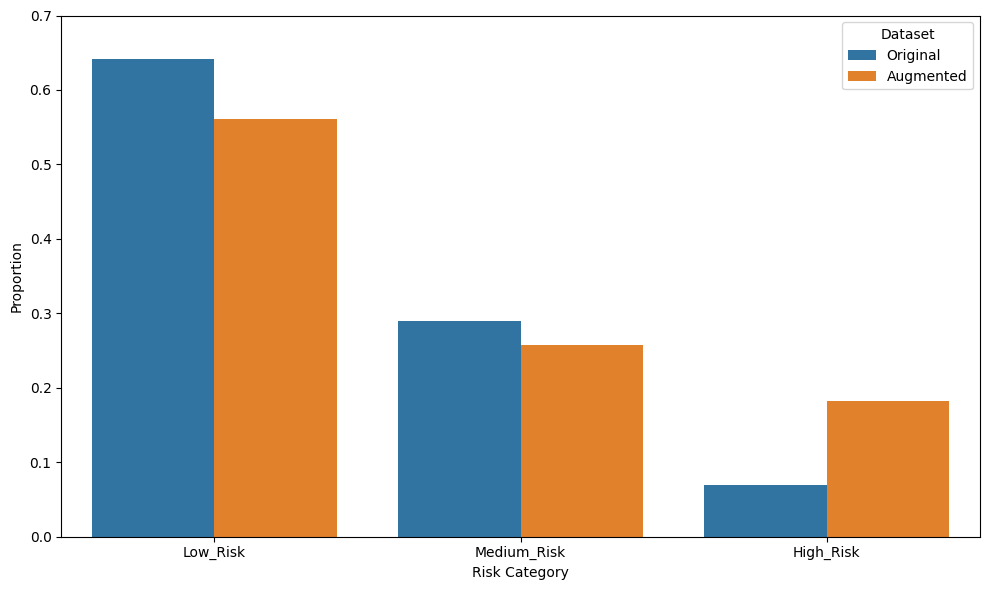

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming user_df and new_user_df from the provided code are available
# Calculate distributions
original_dist = user_df['risk_category'].value_counts(normalize=True).reindex(['Low_Risk', 'Medium_Risk', 'High_Risk']).fillna(0)
augmented_dist = new_user_df['risk_category'].value_counts(normalize=True).reindex(['Low_Risk', 'Medium_Risk', 'High_Risk']).fillna(0)

# Prepare data for plotting
dist_df = pd.DataFrame({
    'Category': ['Low_Risk', 'Medium_Risk', 'High_Risk'],
    'Original': original_dist.values,
    'Augmented': augmented_dist.values
})

# Melt the dataframe for seaborn plotting
dist_melted = dist_df.melt(id_vars='Category', var_name='Dataset', value_name='Proportion')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Proportion', hue='Dataset', data=dist_melted)
plt.xlabel('Risk Category')
plt.ylabel('Proportion')
plt.ylim(0, 0.7)  # Adjust based on data for better visualization
plt.legend(title='Dataset')
plt.tight_layout()

# Show the plot
plt.show()